# TensorFlow for Card Category Classification

In most of the banks, the clients are segmented into categories. This classification is made by looking into an amount of demographic data. We need to develop neural network to, given the demographic and financial data of one client, the model should determine what segment this client is more fit in. 

## Libraries and Dataset

In [106]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras

This dataset is not mine. You can download the original dataset [here](https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m)

In [107]:
dataset = pd.read_csv('datasets/preprocessed_dataset.csv')
dataset

,Unnamed: 0,Customer_Id,Attrition_Flag,Customer_Age,Customer_Gender,Dependent_Count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,N-B_class_1,N-B_class_2,Marital_Status_0,Marital_Status_1,Marital_Status_2,Marital_Status_3
0,0,768805383,Existing Customer,-0.156190,1,0.509985,2,Married,3,1,...,-0.999456,-1.163844,1.625,-0.863732,-0.656780,0.680286,0.0,1.0,0.0,0.0
1,1,818770008,Existing Customer,0.338818,0,2.044726,4,Single,1,1,...,-0.957606,-1.556554,3.714,-0.702295,-0.917399,0.893754,0.0,0.0,1.0,0.0
2,2,713982108,Existing Customer,0.586322,1,0.509985,4,Married,4,1,...,-0.787930,-2.123802,2.333,-1.087543,-1.172269,1.178379,0.0,1.0,0.0,0.0
3,3,769911858,Existing Customer,-0.774949,0,1.277356,2,Unknown,1,1,...,-0.991770,-2.123802,2.333,1.700918,-0.370340,0.395662,0.0,0.0,0.0,1.0
4,4,709106358,Existing Customer,-0.774949,1,0.509985,1,Married,3,1,...,-1.092835,-1.774727,2.500,-1.087543,-1.168031,1.178379,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,10116,714109308,Existing Customer,-0.032438,1,2.044726,3,Single,4,1,...,3.046019,1.890569,0.931,-0.463808,0.046299,-0.031275,0.0,0.0,1.0,0.0
8496,10117,712503408,Existing Customer,1.328834,1,-0.257385,4,Married,4,1,...,3.656399,1.846934,0.820,-0.698626,2.353164,-2.379428,0.0,1.0,0.0,0.0
8497,10120,710841183,Existing Customer,0.957578,1,-1.024755,2,Single,3,1,...,3.109506,1.977837,0.754,-0.533520,-1.049535,1.036067,0.0,0.0,1.0,0.0
8498,10121,713899383,Existing Customer,1.205082,0,-1.024755,4,Single,1,1,...,2.830223,2.239644,0.791,-0.485822,-0.265771,0.253349,0.0,0.0,1.0,0.0


## Preparing the data

First, we need to do a little adjustment on the target column, that is: the card category is set to [1, 2, 3, 4], to Blue, Silver, Gold, and Platinum,
respectively. But, in order to make things easier for the neural network we must begin the card category with 0. So we map the categories to [0, 1, 2, 3].

In [111]:
dataset['Card_Category'] = dataset['Card_Category'].map({
    1: 0,
    2: 1,
    3: 2,
    4: 3
})

Now we set our features list.

In [248]:
features_list = ['Customer_Age',                
                 'Customer_Gender',             
                 'Dependent_Count',            
                 'Education_Level',            
                 'Marital_Status_0',
                 'Marital_Status_1',
                 'Marital_Status_2',
                 'Marital_Status_3',         
                 'Income_Category',            
                 'Months_on_book',             
                 'Total_Relationship_Count',   
                 'Months_Inactive_12_mon',     
                 'Contacts_Count_12_mon',      
                 'Credit_Limit',               
                 'Total_Revolving_Bal',        
                 'Avg_Open_To_Buy',            
                 'Total_Trans_Amt',            
                 'Total_Trans_Ct',             
                 'Avg_Utilization_Ratio',
                 'N-B_class_1',
                 'N-B_class_2']      
            
features = dataset[features_list].fillna(0)
features.head()

,Customer_Age,Customer_Gender,Dependent_Count,Education_Level,Marital_Status_0,Marital_Status_1,Marital_Status_2,Marital_Status_3,Income_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio,N-B_class_1,N-B_class_2
0,-0.156190,1,0.509985,2,0.0,1.0,0.0,0.0,3,0.388889,...,-1.252865,0.595213,0.436364,-0.632973,0.489013,-0.999456,-1.163844,-0.863732,-0.656780,0.680286
1,0.338818,0,2.044726,4,0.0,0.0,1.0,0.0,1,1.012227,...,-1.252865,-0.329538,-0.051833,-0.518152,-0.008614,-0.957606,-1.556554,-0.702295,-0.917399,0.893754
2,0.586322,1,0.509985,4,0.0,1.0,0.0,0.0,4,0.014887,...,-1.252865,-2.179040,-0.584393,-1.658444,-0.445935,-0.787930,-2.123802,-1.087543,-1.172269,1.178379
3,-0.774949,0,1.277356,2,0.0,0.0,0.0,1.0,1,-0.234448,...,1.697912,-1.254289,-0.595951,1.663448,-0.734475,-0.991770,-2.123802,1.700918,-0.370340,0.395662
4,-0.774949,1,0.509985,1,0.0,1.0,0.0,0.0,3,-1.855126,...,-1.252865,-2.179040,-0.441511,-1.658444,-0.303096,-1.092835,-1.774727,-1.087543,-1.168031,1.178379


We set our target column. 

In [113]:
target = dataset['Card_Category']

And now we split the train and test sets. 

In [114]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=42)

In [235]:
x_train.shape

(6800, 21)

## Building the neural network 

Here we need to pay attention to the most important thing about our dataset: it is unbalanced. 93% of the credit card public is in the Blue category. So we need to be sure that our model can choose the correct category for the clients without setting everyone on the Blue category (if so, the model will continue to have great accuracy, but not so good recall and precision.)

To prevent the model from setting everyone in the Blue category, I will create a function to generate weights for the classes. The idea is to give more weight to the Platinum category and less weight to the Blue category hence, we can solve the problem and balance our dataset. The idea for this function I've founded on an article from Towards Data Science, you will find it [here](https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99).

In [126]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

Now we use this function on our train set

In [128]:
class_weights = generate_class_weights(y_train)
n_classes = len(class_weights)

And now we can build the neural network

In [265]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(21,)), # the input layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax') # an output layer with 4 units since we have 4 categories
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
early_stop = keras.callbacks.EarlyStopping(patience=10)
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_57 (Flatten)        (None, 21)                0         
                                                                 
 dense_111 (Dense)           (None, 256)               5632      
                                                                 
 dense_112 (Dense)           (None, 4)                 1028      
                                                                 
Total params: 6660 (26.02 KB)
Trainable params: 6660 (26.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training the neural network

In [266]:
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=100, class_weight=class_weights, callbacks=early_stop)

Epoch 1/100
213/213 [==============================] - 1s 3ms/step - loss: 1.1391 - accuracy: 0.8404 - val_loss: 0.5335 - val_accuracy: 0.8282
Epoch 2/100
213/213 [==============================] - 1s 2ms/step - loss: 0.8197 - accuracy: 0.8368 - val_loss: 0.4189 - val_accuracy: 0.8406
Epoch 3/100
213/213 [==============================] - 1s 3ms/step - loss: 0.8358 - accuracy: 0.8449 - val_loss: 0.4416 - val_accuracy: 0.8400
Epoch 4/100
213/213 [==============================] - 0s 2ms/step - loss: 0.7065 - accuracy: 0.8444 - val_loss: 0.4391 - val_accuracy: 0.8406
Epoch 5/100
213/213 [==============================] - 0s 2ms/step - loss: 0.6815 - accuracy: 0.8506 - val_loss: 0.4092 - val_accuracy: 0.8541
Epoch 6/100
213/213 [==============================] - 0s 2ms/step - loss: 0.6395 - accuracy: 0.8516 - val_loss: 0.3815 - val_accuracy: 0.8582
Epoch 7/100
213/213 [==============================] - 0s 2ms/step - loss: 0.5718 - accuracy: 0.8551 - val_loss: 0.3705 - val_accuracy: 0.8653

I will plot a chart so we can see how the accuracy level rises on the epochs. 

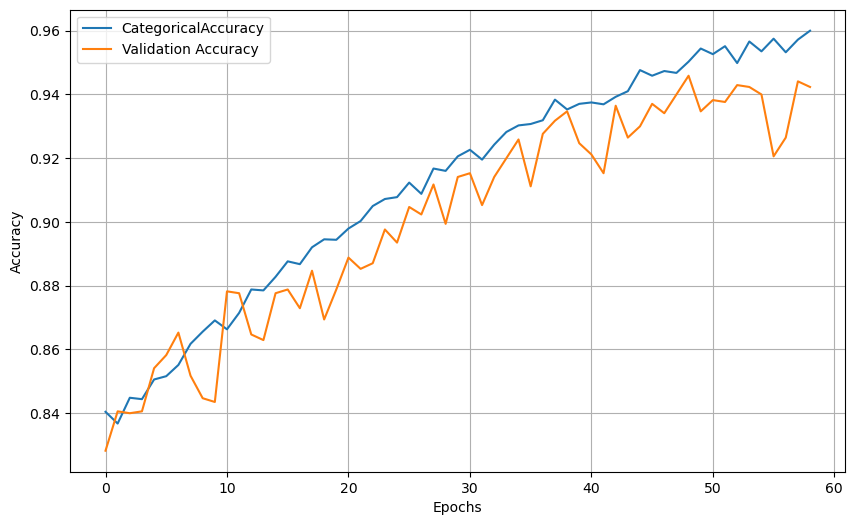

In [267]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10,6))
plt.plot(history_df["accuracy"],label="CategoricalAccuracy")
plt.plot(history_df["val_accuracy"],label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

## Evaluating the model

Now our model is trained. We need to evaluate it. We will use the Confusion Matrix to do so.

In [268]:
prediction = model.predict(x_test)

54/54 [==============================] - 0s 1ms/step


Since the output layer on our model is a 4-unit layer, we have 4 predictions for each entry, that is, we have the probability of a client belonging to each category. Therefore, we have to set the clients in the category with the higher probability. We do this with a little *'for'* loop.

In [269]:
pred = [] #
for i in range(len(prediction)):
    est = np.argmax(prediction[i])
    pred.append(est)

prediction = np.array(pred)

## Confusion Matrix

A Confusion Matrix, also known as Error Matrix, is a specific table layout that allows visualization of the performance of an algorithm.

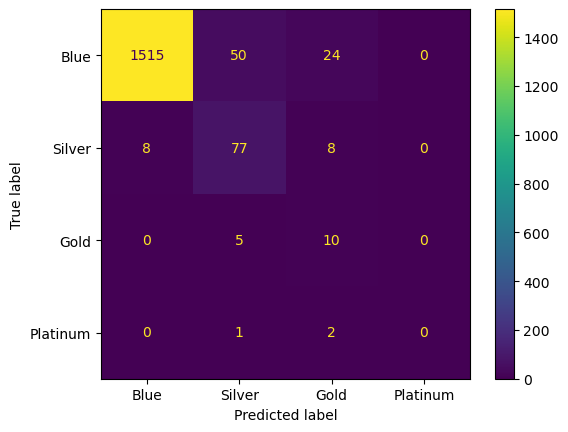

In [270]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_pred=prediction, y_true=y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Blue', 'Silver', 'Gold', 'Platinum'])

cm_display.plot()
plt.show()

## Conclusion

We had a real improvement with this approach instead the k-NN approach (check the '[knn_estimator_for_card_category.ipynb](https://github.com/dennerbocardi/card_categorizer/blob/main/src/knn_estimator_for_card_category.ipynb)'). But I think we can do better. The next step is to do a random forest with a boosting algorithm and see if the model is better for categorizing the clients without suffering from the unbalanced dataset. 

Stay tuned for updates

# Thank You!